# **Data Analysis Notebook**

## Objectives
- Fulfil Business Requirement 1 - the local government wants a study of the patterns and relationships within the student data, with the goal of identifying correlations with the exam scores data

## Inputs
- student-exam-results.csv file

## Outputs
- Various plots and reports that indicate patterns and relationships

In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pingouin as pg
sns.set_theme(style="whitegrid")

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [2]:
import os
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [3]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [4]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

## Load Data

First, we load the dataset output from the Data Collection notebook

In [5]:
import pandas as pd
df = pd.read_csv('outputs/datasets/collection/student-exam-results.csv')
df.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score
0,male,group A,high school,standard,completed,67,67,63,65
1,female,group D,some high school,free/reduced,none,40,59,55,51
2,male,group E,some college,free/reduced,none,59,60,50,56
3,male,group B,high school,standard,none,77,78,68,74
4,male,group E,associate's degree,standard,completed,78,73,68,73


We now want to become more familiar with the dataset. We can do this with a Pandas Profile Report

In [6]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Profile report discussion

In the `gender` column, we see 517 records for male students and 483 records for female students. This indicates that the `gender` column's values are equally distributed, therefore a Machine Learning model that takes a student's gender as an input should not be biased one way or the other.

In the `ethnicity` column, we see that the ethnicities are imbalanced. This could be problematic, as a machine learning model that takes a student's ethnicity as an input would be more reliable when predicting test scores for Group C (323 records) than Group A (79 records).

In the `parental_education` column, we see that the `some college`, `associates degree`, `high school` and `some high school` categories are approximately equally distributed, however the `bachelor's degree` category contains about half as many records. This could be problematic.

In the `lunch_program` column, we see that there are about twice as many `standard` entries as there are `free/reduced` entries. This could prove problematic.

In the `test_preparation_course` column, we see that there are about twice as many `none` entries as there are `completed` entries. This could prove problematic.

We then come to the numerical exam score variables. These appear to be normally distributed. We should check this using histograms

## Distribution Analysis

In this section, we will check to see if the numerical variables of the dataset are, as the Profile Report suggests, normally distributed. First, lets plot some histograms that are larger than those in the profile report, and that have KDE lines.

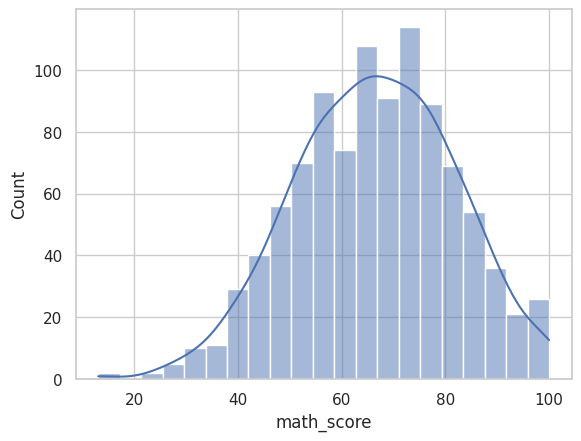

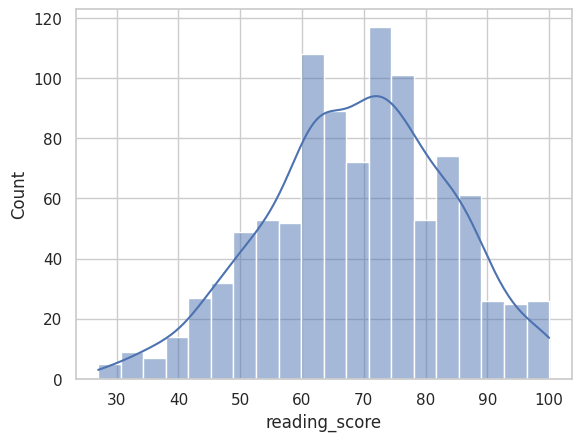

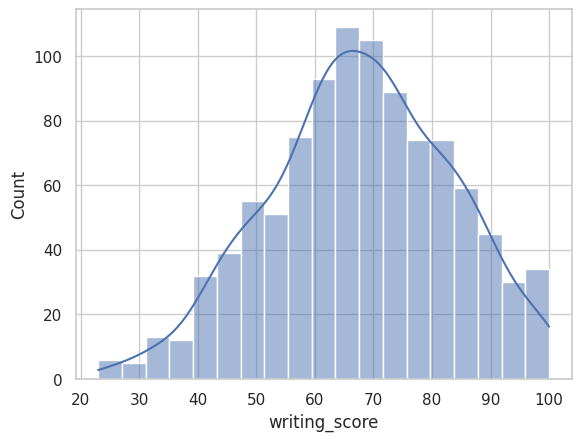

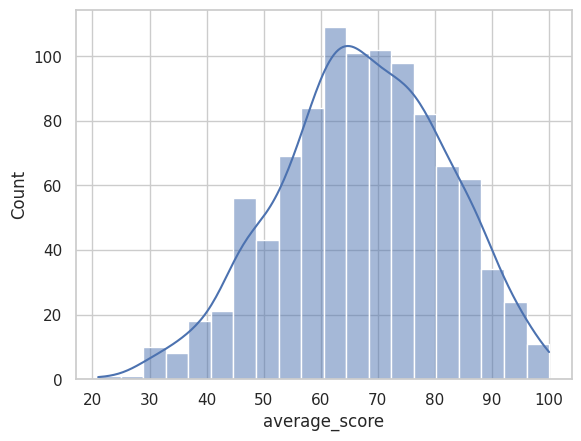

In [7]:
%matplotlib inline
for column in df.columns[5:9]:
    sns.histplot(data=df, kde=True, x=column)
    plt.show()

The histograms appear to show that the numerical variables are normally distributed. We can use the Pingouin library and the Shapiro-Wilk test to mathematically confirm this

In [8]:
pg.normality(data=df, alpha=0.05)

,W,pval,normal
math_score,0.995075,0.002504,False
reading_score,0.993004,0.000118,False
writing_score,0.993029,0.000123,False
average_score,0.993946,0.000454,False


This is an interesting result from the Shapiro-Wilk test. It appears that the plots were misleading us, and that the scores are not normally distributed. We could do some Numerical Data Transformation and use the Box-Cox or Yeo-Johnson transformers.

### Transformers

As a precaution, I will explore the results of the Box-Cox and Yeo-Johnson transformers. If the planned ML pipeline performs poorly on the standard data, we may ascribe this to the abnormally distributed data, and can then test it with the (hopefully) normally distributed data output from the Box-Cox and Yeo-Johnson transformers. Since the transformers are used in pipelines, we can apply a transformer as one of the first steps. 

First, we must import the transformer and the SkLearn Pipeline package

In [9]:
from feature_engine import transformation as vt
from sklearn.pipeline import Pipeline

Now we can define a transformer pipeline using the Box-Cox transformer

In [10]:
pipeline_box_cox = Pipeline([
    ('Box-Cox-Transformer', vt.BoxCoxTransformer())
])

df_box_cox = pipeline_box_cox.fit_transform(df)
df_box_cox.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score
0,male,group A,high school,standard,completed,121.091609,162.702436,113.383625,143.938963
1,female,group D,some high school,free/reduced,none,65.421602,138.343992,96.411057,106.234436
2,male,group E,some college,free/reduced,none,104.072425,141.342768,86.028589,119.442519
3,male,group B,high school,standard,none,142.889175,197.481846,124.198855,169.279935
4,male,group E,associate's degree,standard,completed,145.098631,181.497357,124.198855,166.425182


The transformer appears to have only targeted the numerical variables. We will display the un-transformed df just to be sure that the categorical variables remain unchanged

In [11]:
df.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score
0,male,group A,high school,standard,completed,67,67,63,65
1,female,group D,some high school,free/reduced,none,40,59,55,51
2,male,group E,some college,free/reduced,none,59,60,50,56
3,male,group B,high school,standard,none,77,78,68,74
4,male,group E,associate's degree,standard,completed,78,73,68,73


Excellent. The transformer has not targeted the categorical variables.

Now we can run the Shapiro-Wilk test on the results of the Box-Cox transformer to see if it has more normally distributed the data

In [12]:
pg.normality(data=df_box_cox, alpha=0.05)

,W,pval,normal
math_score,0.995915,0.009541,False
reading_score,0.994572,0.001154,False
writing_score,0.993813,0.000373,False
average_score,0.995235,0.003216,False


It appears that the Box-Cox transformer has failed to more normally distribute the data. We should see what the Yeo-Johnson transformer does

In [13]:
pipeline_yeo_johnson = Pipeline([
    ('Yeo-Johnson-transformer', vt.YeoJohnsonTransformer())
])

df_yeo_johnson = pipeline_yeo_johnson.fit_transform(df)
df_yeo_johnson.head()

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score,reading_score,writing_score,average_score
0,male,group A,high school,standard,completed,124.995453,168.960662,117.198324,149.363122
1,female,group D,some high school,free/reduced,none,68.202992,143.936922,99.872523,110.681893
2,male,group E,some college,free/reduced,none,107.630870,147.017410,89.275144,124.231091
3,male,group B,high school,standard,none,147.239583,204.697330,128.240107,175.366811
4,male,group E,associate's degree,standard,completed,149.494580,188.271726,128.240107,172.437109


Now we check if the data is normally distributed

In [14]:
pg.normality(data=df_yeo_johnson, alpha=0.05)

,W,pval,normal
math_score,0.995914,0.009538,False
reading_score,0.994581,0.001169,False
writing_score,0.993814,0.000374,False
average_score,0.995242,0.003250,False


Blast - it seems both transformers have failed to normally distribute the data. However, this does not mean that the transformations are pointless - they may have improved the normal distribution. We check this with Pinguoin QQ plots, paying particular attention to the R2 score.

Lets construct QQ plots for the untransformed dataset:

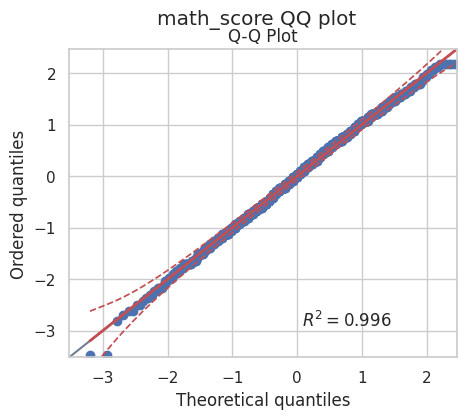

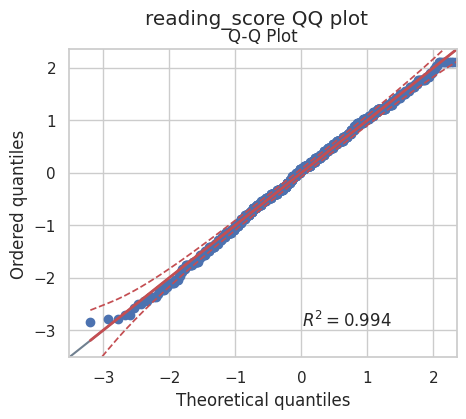

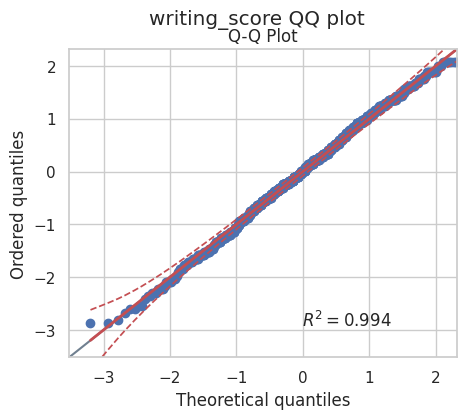

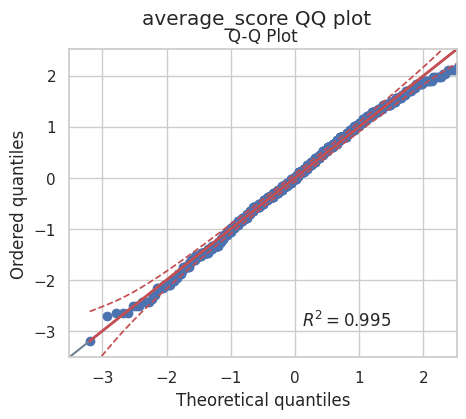

In [15]:
for column in df.columns[5:9]:
    pg.qqplot(df[column], dist='norm')
    plt.suptitle(f'{column} QQ plot')
    plt.show()

This is interesting - we appear to have numerical data that is not, according to the Shapiro-Wilk test, normally distributed. And yet, we have exceptionally good R2 values. We should see what the QQ plots of the transformations are

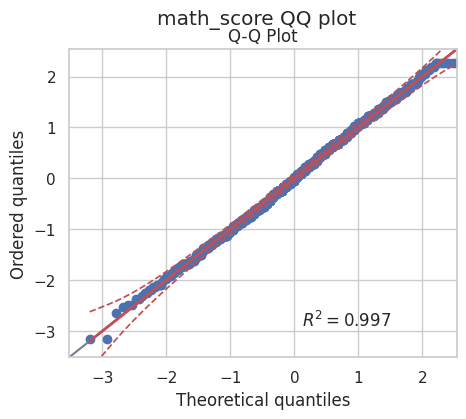

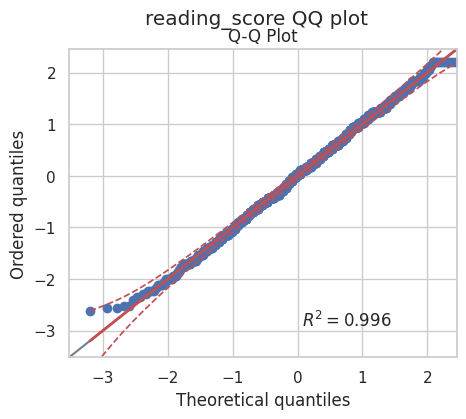

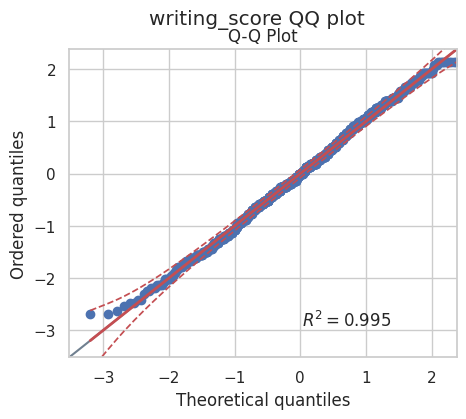

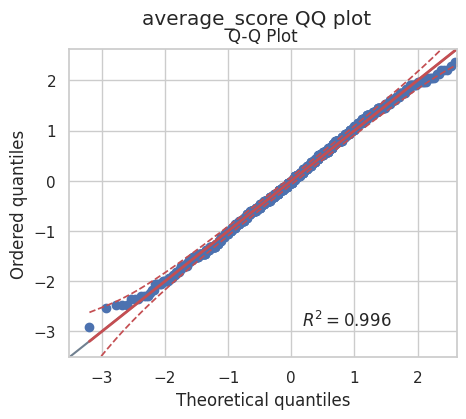

In [16]:
for column in df_box_cox.columns[5:9]:
    pg.qqplot(df_box_cox[column], dist='norm')
    plt.suptitle(f'{column} QQ plot')
    plt.show()

The Box-Cox transformation has improved the R2 scores slightly

Lets see what the Yeo-Johnson transformation has accomplished

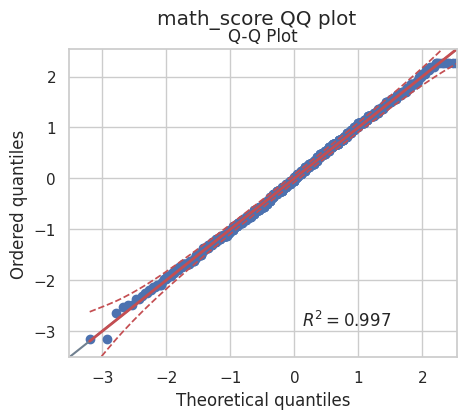

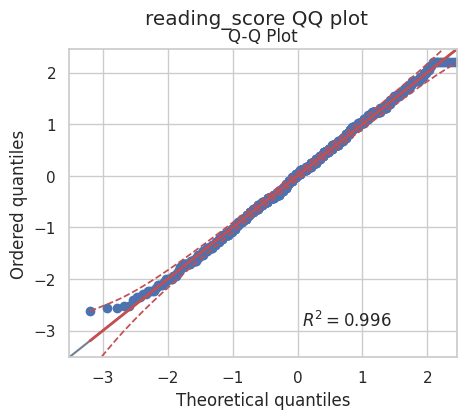

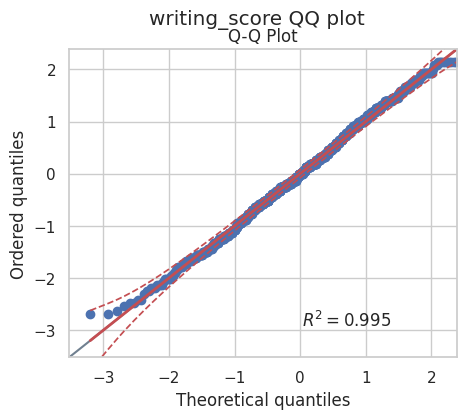

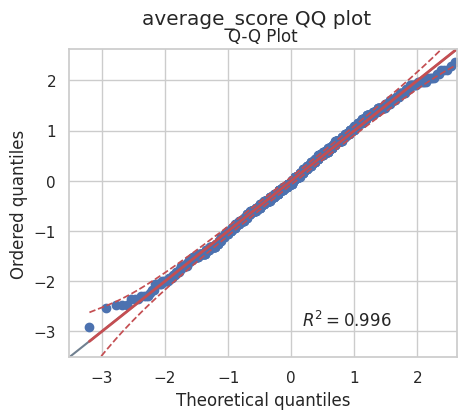

In [17]:
for column in df_yeo_johnson.columns[5:9]:
    pg.qqplot(df_yeo_johnson[column], dist='norm')
    plt.suptitle(f'{column} QQ plot')
    plt.show()

It appears the Yeo-Johnson transformation has achieved similar results to the Box-Cox transformation

Developer's note - after noting that we have contra-indications as to the normality of the numerical data (the Shapiro-Wilk test indicates that the data is not normally distributed, but the QQ plots, R2 scores and histograms visually indicate normal distribution), I put this question to the Code Institute Predictive Analytics Slack channel.  Niel McEwan indicated that outliers in the dataset may be causing the Shapiro-Wilk test to fail. Given that the dataset contains 1000 records, even a few outliers could have an outsized effect. Therefore, we will study the skewness and kurtosis of the data.

### Skewness

We will calculate the skewness of the dataset's numerical variables using the pingouin `skew()` method.

In [18]:
df[5:9].skew()

/tmp/ipykernel_3403/2811257362.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[5:9].skew()


math_score       1.994169
reading_score    0.401362
writing_score    0.505040
average_score    1.168644
dtype: float64

From the output of the skew method, we see that: 
- math_score is very heavily positively skewed - the right-hand-side tail is longer
- reading_score is fairly unskewed
- writing_score is moderately negatively skewed - the left-hand-side tail is longer
- average_score is fairly unskewed

After discussing this with Niel, an argument can be made for writing_score being fairly symmetrical, since the rule of thumb for noticeable skewness is 0.5

### Kurtosis

We can calculate kurtosis using the `kurtosis()` method.  

In [19]:
df[5:10].kurtosis()

/tmp/ipykernel_3403/1821749827.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[5:10].kurtosis()


math_score       2.837033
reading_score   -1.164313
writing_score    0.323486
average_score    0.603491
dtype: float64

From the output of the kurtosis method, we see that: 
- math_score has a very high kurtosis. If we take another look at the Profile Report, we note that the peaks toward the center of the plot are high when compared to the surrounding peaks.
- reading_score has a highly negative kurtosis, indicating that the data is too flat
- writing_score has low kurtosis, indicating close to normal distribution
- average_score has a moderate kurtosis, indicating close to normal distribution

From the Skew and Kurtosis analyses, we note that the math_score variable could prove problematic. The reading_score and writing_score variables could also prove problematic, albeit less-so.

## Conclusions

Given the competing arguments both for and against the data being normally distributed, we have something of a dilemma - is the data normally distributed or not? The Shapiro-Wilk test indicates that none of the 4 numerical columns are normally distributed, but the outputs of the skew and kurtosis methods above indicate that the relatively small number of outliers could be having an outsized effect on that test, causing it to fail. On the other hand, the KDE lines on the histograms as well as the QQ plots and their R2 scores indicate that the data is normally distributed. Given that the Shapiro-Wilk test is a purely statistical test, I am inclined to favour the visual evidence of the QQ plots and KDE lines, and say that the data is normally distributed, with a caveat that the outputs of the skew and kurtosis methods indicate that model training could be problematic.

My Mentor's thoughts on this issue are......

We can now save these plots for use within the Streamlit app

## Save plots

Before we can save any plots, we must first create a directory within which to save them:

In [20]:
import os

try:
  os.makedirs(name='outputs/plots/distribution') # create outputs/plots/distribution folder
except Exception as e:
  print(e)

filepath_distribution = 'outputs/plots/distribution'

Now we can save the plots. Due to how the `savefig()` method works, we will construct each plot differently, however they are effectively the same plots as above. We will save the KDE-histograms that plot distribution, as well as the QQ plots with their R2 scores. We will not save the QQ plots constructed using the outputs of the Yeo-Johnson and Box-Cox transformations, as these, as noted, only improve the R2 scores fractionally, and since we will not use them transformed data again, they serve no further purpose.

rm: cannot remove 'outputs/plots/distribution/math-score-distribution-plot.png': No such file or directory


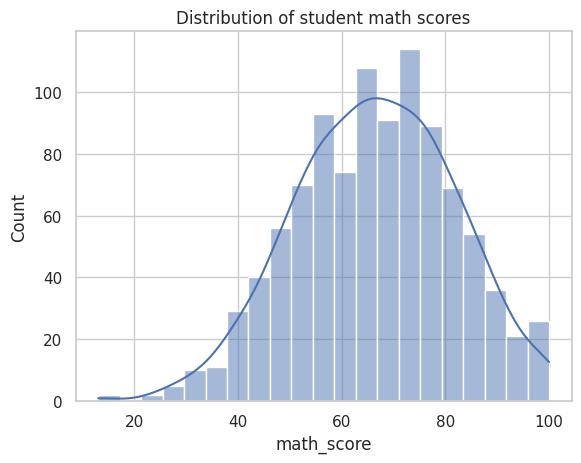

In [24]:
! rm outputs/plots/distribution/math-score-distribution-plot.png

fig_math_score_distribution = sns.histplot(data=df, kde=True, x=df['math_score'])
plt.title("Distribution of student math scores")
plt.savefig(f'{filepath_distribution}/math-score-distribution-plot.png')

rm: cannot remove 'outputs/plots/distribution/reading-score-distribution-plot.png': No such file or directory


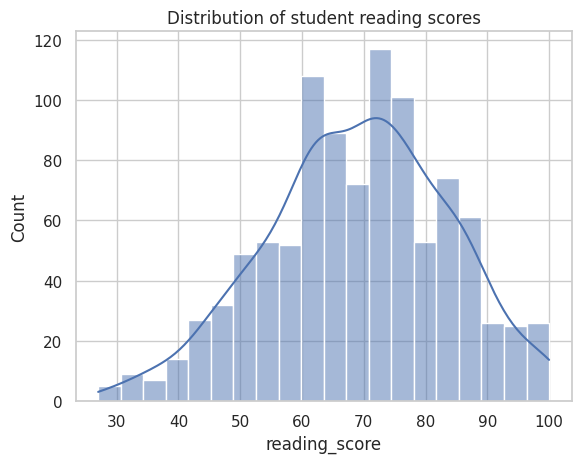

In [23]:
! rm outputs/plots/distribution/reading-score-distribution-plot.png

fig_reading_score_distribution = sns.histplot(data=df, kde=True, x=df['reading_score'])
plt.title("Distribution of student reading scores")
plt.savefig(f'{filepath_distribution}/reading-score-distribution-plot.png')

rm: cannot remove 'outputs/plots/distribution/writing-score-distribution-plot.png': No such file or directory


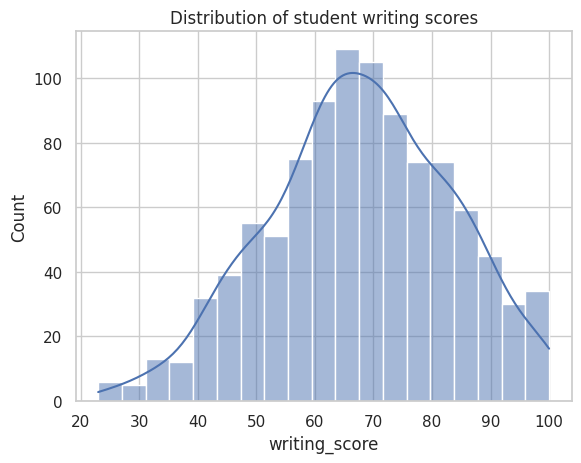

In [25]:
! rm outputs/plots/distribution/writing-score-distribution-plot.png

fig_writing_score_distribution = sns.histplot(data=df, kde=True, x=df['writing_score'])
plt.title("Distribution of student writing scores")
plt.savefig(f'{filepath_distribution}/writing-score-distribution-plot.png')

rm: cannot remove 'outputs/plots/distribution/average-score-distribution-plot.png': No such file or directory


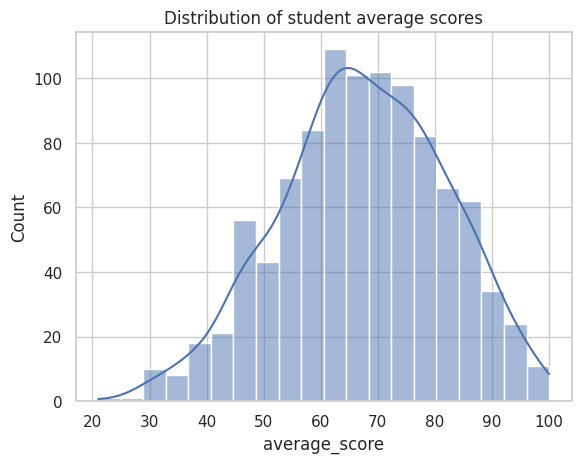

In [26]:
! rm outputs/plots/distribution/average-score-distribution-plot.png

fig_average_score_distribution = sns.histplot(data=df, kde=True, x=df['average_score'])
plt.title("Distribution of student average scores")
plt.savefig(f'{filepath_distribution}/average-score-distribution-plot.png')

Now for the QQ plots

rm: cannot remove 'outputs/plots/distribution/math-score-qq-plot.png': No such file or directory


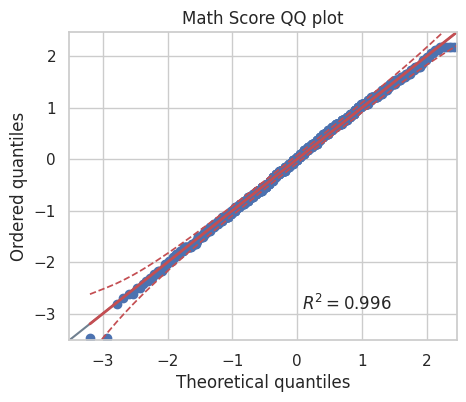

In [28]:
! rm outputs/plots/distribution/math-score-qq-plot.png

fig_math_score_qq_plot = pg.qqplot(df['math_score'], dist='norm')
plt.title("Math Score QQ plot")
plt.savefig(f'{filepath_distribution}/math-score-qq-plot.png')

rm: cannot remove 'outputs/plots/distribution/reading-score-qq-plot.png': No such file or directory


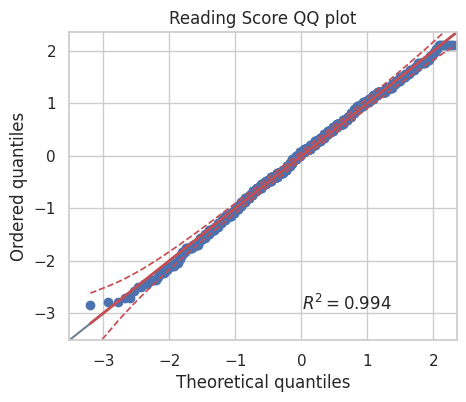

In [29]:
! rm outputs/plots/distribution/reading-score-qq-plot.png

fig_reading_score_qq_plot = pg.qqplot(df['reading_score'], dist='norm')
plt.title("Reading Score QQ plot")
plt.savefig(f'{filepath_distribution}/reading-score-qq-plot.png')

rm: cannot remove 'outputs/plots/distribution/writing-score-qq-plot.png': No such file or directory


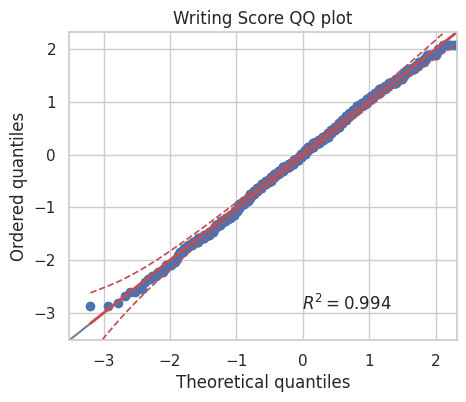

In [30]:
! rm outputs/plots/distribution/writing-score-qq-plot.png

fig_writing_score_qq_plot = pg.qqplot(df['writing_score'], dist='norm')
plt.title("Writing Score QQ plot")
plt.savefig(f'{filepath_distribution}/writing-score-qq-plot.png')

rm: cannot remove 'outputs/plots/distribution/average-score-qq-plot.png': No such file or directory


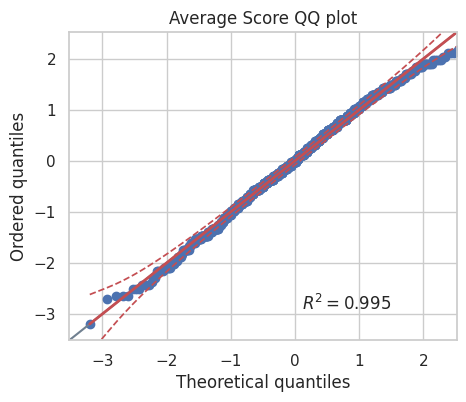

In [31]:
! rm outputs/plots/distribution/average-score-qq-plot.png

fig_average_score_qq_plot = pg.qqplot(df['average_score'], dist='norm')
plt.title("Average Score QQ plot")
plt.savefig(f'{filepath_distribution}/average-score-qq-plot.png')

Excellent - in the next notebook, we will examine the relationships between the categorical feature variables and the numerical target variables.